# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [31]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [11]:
type(asl)

asl_data.AslDb

In [33]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [34]:
# asl.df.head()
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y'] # new column in dataframe
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [66]:
# from asl_utils import test_features_tryit
# asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
# asl.df.head()

In [36]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [45]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly'] 

 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [46]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['IX-1P', 'PUTASIDE', 'FRED', 'MARY', 'FUTURE', 'VEGETABLE', 'NEW', 'SEARCH-FOR', 'MAN', 'CHINA', 'WONT', 'SELF', 'GIVE2', 'WRITE', 'STOLEN', 'NEW-YORK', 'SAY-1P', 'WANT', 'BOY', 'BROCCOLI', 'PAST', 'JOHN', 'MOVIE', 'HAVE', 'BUT', 'WILL', 'GO1', 'SHOOT', 'GIVE3', 'PEOPLE', 'TOY', 'CANDY', 'HOMEWORK', 'MANY', 'COAT', 'GO', 'VISIT', 'CHOCOLATE', 'ANN', 'WHO', 'IX', 'LIVE', 'CHICKEN', 'JANA', 'SOMETHING-ONE', 'SHOULD', 'TOMORROW', 'THINK', 'BREAK-DOWN', 'FRANK', 'FRIEND', 'GIVE1', 'TELL', 'FISH', 'PREFER', 'FIND', 'LEG', 'CORN1', 'HOUSE', 'HERE', 'NAME', 'YESTERDAY', 'HIT', 'GO2', 'SELL', 'GET', 'BUY', 'POSS', 'SEE', 'DECIDE', 'TEACHER', 'BLUE', 'ARRIVE', 'GROUP', 'GIRL', 'WOMAN', 'APPLE', 'NEXT-WEEK', 'GIVE', 'BOOK', 'CAN', 'SUE', 'LAST-WEEK', 'LEAVE', 'BILL', 'FINISH', 'FUTURE1', 'PARTY', 'KNOW', 'VIDEOTAPE', 'THROW', 'ALL', 'EAT', 'WHAT', 'BORROW', 'OLD', 'MOTHER', 'TOY1', 'NOT', 'BUY1', 'SAY', 'BROTHER', 'CHICAGO', 'BOX', 'STUDENT', 'LOVE', 'LIKE', 'CORN', 'READ', 'BLA

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [58]:
# training.get_word_sequences('CHOCOLATE')

In [59]:
# training.get_word_Xlengths('ALL')

In [60]:
# training.get_word_Xlengths('ALL')

In [47]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [61]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [83]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x']) # mapping speaker with left-x value obtained in df_means
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [86]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std() # std. deviation
# df_std
# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [94]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_original = ['right-x', 'right-y', 'left-x', 'left-y']
normalize = zip(features_norm, features_original)
for normal, original in normalize:
    X_mean = asl.df['speaker'].map(df_means[original]) # from [61], [83]
    X_std = asl.df['speaker'].map(df_std[original])
    X = asl.df[original]
    asl.df[normal] = (X - X_mean) / X_std # convenience
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly   polar-rr  polar-rtheta  \
video frame                                                          
98    0      1.663433 -0.891199  0.741835  113.35784      0.079478   
      1      1.663433 -0.891199  0.741835  113.35784      0.079478   
      2      1.663433 -0.891199  0.741835  113.35784      0.079478   
      3      1.663433 -0.891199  0.741835  113.35784      0.079478   
      4      1.663433 -0.891199  0.741835  113.35784      0.079478   

               polar-lr  polar-ltheta  
video frame                            
98    0      119.603512     -0.100501  
      1      119.603512     -0.100501  
      2      119.603512     -0.100501  
      3      119.603512     -0.100501  
      4      119.603512     -0.100501

In [100]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
features_grnd = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

# polar = sqrt(x^2 + y^2)
# brute force

asl.df[features_polar[0]] = np.sqrt(asl.df[features_grnd[0]]**2 + asl.df[features_grnd[1]]**2)
asl.df[features_polar[1]] = np.arctan2(asl.df[features_grnd[0]], asl.df[features_grnd[1]])
asl.df[features_polar[2]] = np.sqrt(asl.df[features_grnd[2]]**2 + asl.df[features_grnd[3]]**2)
asl.df[features_polar[3]] = np.arctan2(asl.df[features_grnd[2]], asl.df[features_grnd[3]])

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly   polar-rr  polar-rtheta  \
video frame                                                          
98    0      1.663433 -0.891199  0.741835  113.35784      0.079478   
      1      1.663433 -0.891199  0.741835  113.35784      0.079478   
      2      1.663433 -0.891199  0.741835  113.35784      0.079478   
      3      1.663433 -0.891199  0.741835  113.35784      0.079478   
      4      1.663433 -0.891199  0.741835  113.35784      0.079478   

               polar-lr  polar-ltheta  
video frame                            
98    0      119.603512     -0.100501  
      1      119.603512     -0.100501  
      2      119.603512     -0.100501  
      3      119.603512     -0.100501  
      4      119.603512     -0.100501

In [107]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
features_original = ['right-x', 'right-y', 'left-x', 'left-y']
deltas = zip(features_delta, features_original) # from [94]
for (delta, original) in deltas:
    asl.df[delta] = asl.df[original].diff().fillna(value=0)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 24 columns]

In [114]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

# adding additional delta; from [107]

features_custom = ['custom_rx', 'custom_ry', 'custom_lx', 'custom_ly']
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
deltas = zip(features_custom, features_delta) # from [107]
for (custom, delta) in deltas:
    asl.df[custom] = asl.df[delta].diff(periods=1) # between 2 time periods
    asl.df = asl.df.fillna(value=0)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...        polar-lr  polar-ltheta  \
video frame                               ...                                 
98    0          113        9      119    ...      119.603512     -0.100501   
      1          113        9      119    ...      119.603512     -0.100501   
      2          113        9      119    ...      119.603512     -0.100501   
      3          113        9      119    ...      119.603512     -0.100501   
      4          113        9      119    ...      119.603512     -0.100501   

             delta-rx  delta-ry  delta-lx  delta-ly  custom_rx  custom_ry  \
video frame                                                                 
98    0           0.0       0.0       0.0       0.0        0.0        0.0   
      1           0.0       0.0       0.0       0.0        0.0        0.0   
      2           0.0       0.0       0.0       0.0        0.0        0.0   
      3           0.0       0.0       0.0       0.0        0.0        0.0   
      4           0.0       0.0       0.0       0.0        0.0        0.0   

             custom_lx  custom_ly  
video frame                        
98    0            0.0        0.0  
      1            0.0        0.0  
      2            0.0        0.0  
      3            0.0        0.0  
      4            0.0        0.0  

[5 rows x 28 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** In the above case, custom_features choosen is another set of delta, i.e. adding additional set of delta. This procedure is very similar to the one in which we add features for left, right, x, y differences by one time step. In this choice we take a delta between the already existing delta, with minor change, in this case we take a delta difference between consecutive time period.

As explained, the features in the HMM gets accumulated through time, and when we have more features it helps the model distinguish between two behaviours or signs better if we have more detailed difference or transitions through time. The more detailed transition through time will also helps in better understanding of signs, even in those cases where phrases are involved to interpret.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [117]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.022s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [127]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths) # Baum Welch Expectation Maximization
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


In [128]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]

hidden state #1
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #2
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]



In [125]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths) # Baum Welch Expectation Maximization
    logL = model.score(X, lengths)
    return model, logL

demoword = 'CHOCOLATE'
model, logL = train_a_word(demoword, 5, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 5
logL = -544.2490114712293


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [126]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ -6.37753172  51.09767101   3.64019095 104.46455217]
variance =  [ 10.28279876  12.43850367  27.33782827 106.89825397]

hidden state #1
mean =  [-4.93673736 64.73126904  1.62601029 84.91542811]
variance =  [ 6.16147276 28.36727822  5.4706657  13.12675543]

hidden state #2
mean =  [  3.32089022  86.11784619  12.66977977 102.36987409]
variance =  [12.48273231  7.43528515 12.86407411 24.73804616]

hidden state #3
mean =  [-9.23826304 55.30740641  6.92298855 71.30558162]
variance =  [16.30897315 45.96991798  3.76848558 15.98402053]

hidden state #4
mean =  [ -7.70665738  93.36393433  12.99292645 127.06351815]
variance =  [29.53966949 13.52107768  0.66764483 48.4385572 ]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [131]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 8, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 13, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

# more number of representation through hidden state better the representation
# greater logL value for a given testword and feature on which the HMM is trained

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-5.40587658 60.1652424   2.32479599 91.3095432 ]
variance =  [  7.95073876  64.13103127  13.68077479 129.5912395 ]

hidden state #1
mean =  [  0.58333333  87.91666667  12.75       108.5       ]
variance =  [ 39.41055556  18.74388889   9.855      144.4175    ]

hidden state #2
mean =  [-9.30211403 55.32333876  6.92259936 71.24057775]
variance =  [16.16920957 46.50917372  3.81388185 15.79446427]

logL = -601.3291470028628



Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [-9.23826304 55.30740641  6.92298855 71.30558162]
variance =  [16.30897315 45.96991798  3.76848558 15.98402053]

hidden state #1
mean =  [ -7.70665738  93.36393433  12.99292645 127.06351815]
variance =  [29.53966949 13.52107768  0.66764483 48.4385572 ]

hidden state #2
mean =  [ -6.37753172  51.09767101   3.64019095 104.46455217]
variance =  [ 10.28279876  12.43850367  27.33782827 106.89825397]

hidden state #3
mea

In [132]:
my_testword = 'ALL'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'ALL'
model, logL = train_a_word(my_testword, 3, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'ALL'
model, logL = train_a_word(my_testword, 3, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
print("\n\n")
my_testword = 'ALL'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))




Number of states trained in model for ALL is 3
hidden state #0
mean =  [-67.00010712  38.59997686  31.69995974 179.80004591]
variance =  [32.80088744  6.64130853  2.0109396   0.96088721]

hidden state #1
mean =  [-41.23514926  16.51458103  26.81887957 178.51358133]
variance =  [92.75874885 44.23348763  7.21043514 21.27413749]

hidden state #2
mean =  [-83.31632702  27.1533751   18.56656316 181.56619811]
variance =  [164.42988776  18.68400265   3.95864007   1.0929442 ]

logL = -241.47656488278307



Number of states trained in model for ALL is 3
hidden state #0
mean =  [ 4.3333323  -5.33333184 -2.66666586 -3.9999988 ]
variance =  [ 9.55889258 30.89222084  2.89222349 10.6700016 ]

hidden state #1
mean =  [-2.04841005  0.61979569  0.          0.        ]
variance =  [9.62805450e+00 1.91152429e+00 8.57601963e-04 8.57601963e-04]

hidden state #2
mean =  [ 5.26229538 -4.58381446  0.          0.        ]
variance =  [1.16779092e+02 5.63885528e+00 1.19910144e-03 1.19910144e-03]

logL = -42.616

In [134]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-9.30211403 55.32333876  6.92259936 71.24057775]
variance =  [16.16920957 46.50917372  3.81388185 15.79446427]

hidden state #1
mean =  [  0.58333333  87.91666667  12.75       108.5       ]
variance =  [ 39.41055556  18.74388889   9.855      144.4175    ]

hidden state #2
mean =  [-5.40587658 60.1652424   2.32479599 91.3095432 ]
variance =  [  7.95073876  64.13103127  13.68077479 129.5912395 ]

logL = -601.3291470028619


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [135]:
%matplotlib inline

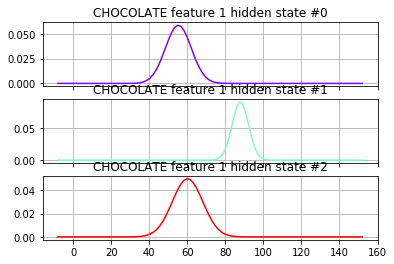

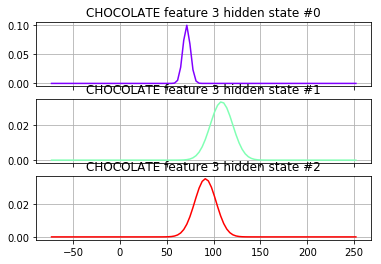

In [137]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

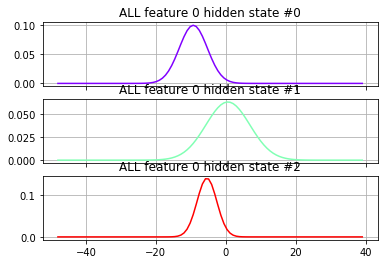

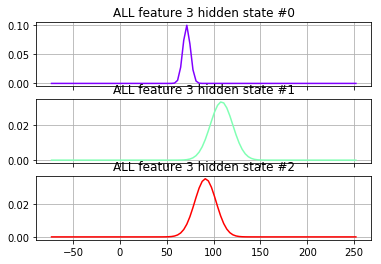

In [139]:
visualize('ALL', model)

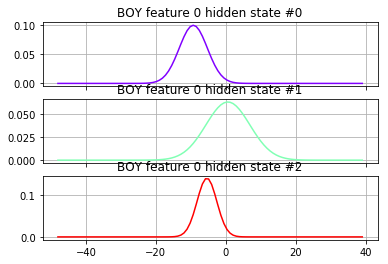

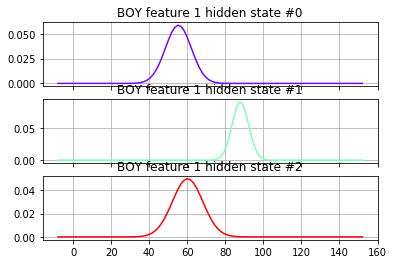

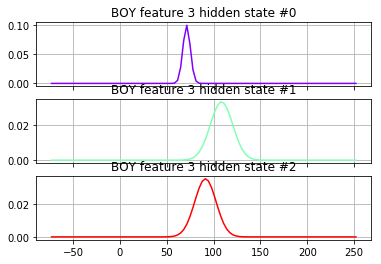

In [142]:
visualize('BOY', model)
# for the three visulaization input model distribution is almost the same, if not same

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [145]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

# experiment from here
print("\n\n")
training = asl.build_training(features_custom)
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))
print("\n\n")
training = asl.build_training(features_delta)
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))
print("\n\n")
training = asl.build_training(features_grnd)
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))
print("\n\n")
training = asl.build_training(features_norm)
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3



Number of states trained in model for VEGETABLE is 3



Number of states trained in model for VEGETABLE is 3



Number of states trained in model for VEGETABLE is 3



Number of states trained in model for VEGETABLE is 3


In [152]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

# experiment from here
# why train and strain if feature is same
print("\n\n")
# training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'ALL' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=5).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))
print("\n\n")
# training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'CHOCOLATE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=8).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))
print("\n\n")
# training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'BOY' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))


# n_constant determines number of states that are being trained for a particular word in the model

Number of states trained in model for VEGETABLE is 3



Number of states trained in model for ALL is 5



Number of states trained in model for CHOCOLATE is 8



Number of states trained in model for BOY is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [149]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


In [151]:
from sklearn.model_selection import KFold

training = asl.build_training(features_custom) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

print("\n\n")
training = asl.build_training(features_norm) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]



Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


In [161]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
# print(word_sequences)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
print("\n\n")
# training = asl.build_training(features_ground) # Experiment here with different feature sets
# word = 'ALL' # Experiment here with different words
# word_sequences = training.get_word_sequences(word)
# split_method = KFold()
# for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
#     print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
# print("\n\n")
training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'CHOCOLATE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]



Train fold indices:[1 2] Test fold indices:[0]
Train fold indices:[0 2] Test fold indices:[1]
Train fold indices:[0 1] Test fold indices:[2]


In [166]:
training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'FISH' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
# print(word_sequences)
split_method = KFold(n_splits=2) # n_splits 
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
print("\n\n")


Train fold indices:[1] Test fold indices:[0]
Train fold indices:[0] Test fold indices:[1]





**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [163]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [215]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'JOHN' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
print(word_sequences)
print(len(word_sequences))

print("\n\n")

word = 'FUTURE'
word_sequences = training.get_word_sequences(word)
print(word_sequences)
print(len(word_sequences))


[[[4, 76, -9, 121], [0, 62, -10, 121], [-4, 49, -10, 122], [-10, 38, -10, 121], [-12, 32, -10, 122], [-13, 27, -8, 120], [-13, 23, -8, 121], [-16, 21, -9, 121], [-16, 21, -8, 120], [-15, 21, -8, 120]], [[-25, 21, 9, 130], [-26, 21, 11, 128], [-27, 23, 9, 131], [-29, 22, 6, 128], [-29, 22, 7, 129], [-29, 23, 8, 129], [-29, 21, 10, 127], [-28, 23, 10, 131], [-29, 21, 10, 131], [-28, 21, 8, 127], [-27, 21, 8, 129], [-25, 19, 10, 131]], [[-3, 83, -22, 124], [-10, 72, -20, 122], [-11, 58, -20, 123], [-14, 46, -21, 122], [-18, 37, -21, 124], [-16, 36, -21, 123], [-18, 26, -18, 121], [-19, 25, -25, 124], [-21, 20, -19, 122], [-16, 21, -16, 125], [-20, 19, -14, 124], [-16, 24, -16, 124]], [[-3, 33, 1, 124], [-5, 29, 1, 124], [-5, 32, 0, 124], [-6, 30, 0, 124], [-9, 28, 0, 124], [-10, 33, 0, 123], [-8, 33, 3, 123], [-8, 35, 3, 121], [-8, 32, 1, 120], [-8, 35, 1, 121], [-7, 34, 1, 121], [-8, 37, 0, 121], [-8, 35, 2, 122], [-10, 35, 4, 120], [-8, 37, 2, 122], [-9, 36, 2, 121], [-7, 36, 2, 120], [

In [217]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 1.2928237409942085 seconds
Training complete for BOOK with 6 states with time 10.185387118996005 seconds
Training complete for VEGETABLE with 2 states with time 3.5164856600022176 seconds
Training complete for FUTURE with 2 states with time 8.099314885010244 seconds
Training complete for JOHN with 12 states with time 77.21986788499635 seconds


In [218]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 1.1919189710024511 seconds
Training complete for BOOK with 9 states with time 11.981998026996735 seconds
Training complete for VEGETABLE with 5 states with time 4.9797469999903115 seconds
Training complete for FUTURE with 2 states with time 6.928526913005044 seconds
Training complete for JOHN with 11 states with time 94.59997062200273 seconds


In [219]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.831582797007286 seconds
Training complete for BOOK with 5 states with time 15.879354245000286 seconds
Training complete for VEGETABLE with 2 states with time 4.968704333005007 seconds
Training complete for FUTURE with 5 states with time 11.11227817600593 seconds
Training complete for JOHN with 6 states with time 106.18341903400142 seconds


In [179]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.5439600990066538 seconds
Training complete for BOOK with 8 states with time 2.601471197005594 seconds
Training complete for VEGETABLE with 9 states with time 0.9767452990054153 seconds
Training complete for FUTURE with 9 states with time 2.772975480009336 seconds
Training complete for JOHN with 13 states with time 23.761441237991676 seconds


In [180]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.5444909899961203 seconds
Training complete for BOOK with 8 states with time 3.951551682999707 seconds
Training complete for VEGETABLE with 3 states with time 1.2268600590032293 seconds
Training complete for FUTURE with 5 states with time 2.5851271060091676 seconds
Training complete for JOHN with 6 states with time 29.12487098699785 seconds


In [181]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.7483082910039229 seconds
Training complete for BOOK with 5 states with time 3.3414896710019093 seconds
Training complete for VEGETABLE with 5 states with time 1.0917763799952809 seconds
Training complete for FUTURE with 7 states with time 2.9896868570067454 seconds
Training complete for JOHN with 15 states with time 28.339525200994103 seconds


In [183]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.2119300269987434 seconds
Training complete for BOOK with 15 states with time 5.82239200299955 seconds
Training complete for VEGETABLE with 15 states with time 4.251391370999045 seconds
Training complete for FUTURE with 15 states with time 5.992937044997234 seconds
Training complete for JOHN with 15 states with time 28.784309677997953 seconds


In [184]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 6 states with time 1.868785222992301 seconds
Training complete for BOOK with 6 states with time 7.485170603002189 seconds
Training complete for VEGETABLE with 2 states with time 4.20842799100501 seconds
Training complete for FUTURE with 15 states with time 6.225659413001267 seconds
Training complete for JOHN with 10 states with time 51.04233185600606 seconds


In [185]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 3.1337463000090793 seconds
Training complete for BOOK with 15 states with time 5.128450277989032 seconds
Training complete for VEGETABLE with 5 states with time 3.604553388999193 seconds
Training complete for FUTURE with 15 states with time 5.401061944998219 seconds
Training complete for JOHN with 15 states with time 31.419191877997946 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**Cross Validation**:

The advantage of this model is that it iterates through the model several time, in order to minimize the error and provide better generalization for the model. The model is split into training and testing dataset, so that it can test over the portion of test dataset how well it is performing. Although special care must be taken for sequences with length 1, for which same data is used for training and to score the model based on the same data which was used for training.

However, there are drawbacks as well, in case large number of iterations aren't allowed, the model might fail to learn appropriately and reduce the error which would barely resemble an ideal model, plus, if number of training samples aren't enough the model might fail to generalize well over the dataset. Also, this can be observed for model with larger sequence representation take more time to train itself, which is evident from case of "JOHN" where this model takes more time compared to other model selectors.

**Bayesian Information Criterion**:

The advantage of this model selector is, its realtively easier in computation. The model results in lesser BIC value when the complexity increases thereby specifying how model's performance increases considerably with the increase in number of parameter which also gives intuitive sense that more number of states defined for a given word, the better a model can also differentiate between the 2 words.

The disadvantage is of this model selector is how, the number of parameters increases the complexity of calculation. As the number of parameter increases, the complexity increases quaratically. Although the model does a really good job penalizing the increase in number of parameters, but this quadratic growth might limit the model selector to problems of smaller corpus of dataset.

**Discriminative Information Criterion**:

This model is relatively complex to Bayesian Information Criterion. In order to perform training on a given word, it performs 2 operations, one which calculates the log likelihood of the current word under training similar to BIC, and another operation which is referred as anti-likelihood for rest of the words in the training dataset. This model tries to maximize the likelihood and minimize the anti-likelihood so as to reduce the error in its training. Since the anti-likelihood is calculated on all the words in the dataset except that under current inspection this adds to additional time complexity during training of the model.

The advantage of this model is its easier to calculate each of the operations, as the likelihood calculation is similar to that of BIC.



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [211]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 111.311s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [222]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

# Experiment
models = train_all_words(features_norm, SelectorCV)
print("Number of word models returned = {}".format(len(models)))
models = train_all_words(features_delta, SelectorDIC)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112
Number of word models returned = 112
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [223]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [224]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [226]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6741573033707865
Total correct: 58 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *GO *BOOK *ARRIVE                                             JOHN WRITE HOMEWORK
   67: *LIKE FUTURE NOT BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
  201: JOHN *GIVE *GIVE *LOVE *ARRIVE HOUSE                          JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT *GO *GO                                            JOHN NOT VISIT MARY
  119: *PREFER *BUY1 IX *BLAME *IX                                   SUE BUY IX CAR BLUE
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: *FRANK *STUDENT YESTERDAY *TEACHER BOOK        

In [228]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.797752808988764
Total correct: 36 out of 178
Video  Recognized                                                    Correct
  100: *JOHN *BREAK-DOWN *ARRIVE *JOHN                               POSS NEW CAR BREAK-DOWN
    2: *MARY *JOHN *JOHN                                             JOHN WRITE HOMEWORK
   67: JOHN *JOHN *JOHN *JOHN *HAVE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BOOK *GIVE1 *TEACHER                                    JOHN CAN GO CAN
  201: JOHN *JOHN *JOHN *JOHN *JOHN *GO                              JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *JOHN *JOHN                                        JOHN NOT VISIT MARY
  119: *JOHN *BUY1 *BLAME *PEOPLE *WHAT                              SUE BUY IX CAR BLUE
   12: JOHN *BOX *JOHN *JOHN                                         JOHN CAN GO CAN
   77: *JOHN *BUY1 *JOHN                                             ANN BLAME MARY
  142: JOHN BUY *JOHN *JOHN *JOHN                      

In [230]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
  201: JOHN *MAN *MAN *LIKE BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *CAR CAR *GO                                    SUE BUY IX CAR BLUE
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [231]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6573033707865169
Total correct: 61 out of 178
Video  Recognized                                                    Correct
  100: *JOHN *ARRIVE CAR *HOUSE                                      POSS NEW CAR BREAK-DOWN
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
   67: JOHN *JOHN *MARY BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *GIVE1 *GIVE1 *ARRIVE                                    JOHN CAN GO CAN
  201: JOHN *IX *JOHN *JOHN BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *IX MARY                                           JOHN NOT VISIT MARY
  119: *JOHN *GIVE1 IX CAR *MARY                                     SUE BUY IX CAR BLUE
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   77: *JOHN *ARRIVE MARY                                            ANN BLAME MARY
  142: JOHN BUY *FUTURE WHAT *WHAT                    

In [232]:
# TODO Choose a feature set and model selector
features = features_original # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6123595505617978
Total correct: 69 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
   67: JOHN *IX *FUTURE *ARRIVE HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: *MARY *PEOPLE GO *ARRIVE                                      JOHN CAN GO CAN
  201: JOHN *FUTURE MARY *MARY *BLAME HOUSE                          JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT VISIT MARY                                         JOHN NOT VISIT MARY
  119: SUE *BUY1 IX *BLAME *GO                                       SUE BUY IX CAR BLUE
   12: JOHN *TEACHER *GO1 CAN                                        JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [235]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.8033707865168539
Total correct: 35 out of 178
Video  Recognized                                                    Correct
  100: *JOHN *MARY *JOHN *BOX                                        POSS NEW CAR BREAK-DOWN
    2: JOHN *JOHN *JOHN                                              JOHN WRITE HOMEWORK
   67: JOHN *JOHN *JOHN *JOHN *JOHN                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BOOK *JOHN *BOOK                                        JOHN CAN GO CAN
  201: JOHN *JOHN *JOHN *JOHN *JOHN *JOHN                            JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *JOHN *JOHN                                        JOHN NOT VISIT MARY
  119: *JOHN *CAR IX CAR *IX                                         SUE BUY IX CAR BLUE
   12: JOHN *HOUSE *JOHN *JOHN                                       JOHN CAN GO CAN
   77: *JOHN *BOOK *JOHN                                             ANN BLAME MARY
  142: JOHN *BOOK *JOHN *JOHN *JOHN                   

In [236]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
  100: *JOHN NEW CAR BREAK-DOWN                                      POSS NEW CAR BREAK-DOWN
    2: JOHN *LOVE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: JOHN *JOHN *MARY BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *STUDENT *GIVE1 *STUDENT                                 JOHN CAN GO CAN
  201: JOHN *IX MARY *IX BUY HOUSE                                   JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *IX MARY                                           JOHN NOT VISIT MARY
  119: *JOHN *BUY1 IX CAR *MARY                                      SUE BUY IX CAR BLUE
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   77: *JOHN *CAR MARY                                               ANN BLAME MARY
  142: JOHN BUY *FUTURE WHAT *MARY                    

In [237]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
  100: *JOHN NEW CAR *BOOK                                           POSS NEW CAR BREAK-DOWN
    2: JOHN *IX *GO1                                                 JOHN WRITE HOMEWORK
   67: JOHN *IX *IX *BUT HOUSE                                       JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE *GIVE1 *TEACHER                                    JOHN CAN GO CAN
  201: JOHN *MARY MARY *JOHN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *IX *MARY MARY                                           JOHN NOT VISIT MARY
  119: *JOHN *GIVE1 IX CAR *IX                                       SUE BUY IX CAR BLUE
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   77: *JOHN *CAR MARY                                               ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [238]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
  201: JOHN *MAN *WOMAN *JOHN BUY HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *GO MARY                                              JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [239]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5674157303370787
Total correct: 77 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *WHO *COAT *NEW                                               JOHN WRITE HOMEWORK
   67: JOHN *YESTERDAY NOT BUY HOUSE                                 JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE *IX *WHAT                                          JOHN CAN GO CAN
  201: JOHN *SHOULD *WOMAN *LOVE BUY HOUSE                           JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *BILL *BILL MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *HAVE *HAVE *SEE                                SUE BUY IX CAR BLUE
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN *NEW YESTERDAY *TEACHER BOOK              

In [240]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.8033707865168539
Total correct: 35 out of 178
Video  Recognized                                                    Correct
  100: *JOHN *BREAK-DOWN *BOX *JOHN                                  POSS NEW CAR BREAK-DOWN
    2: JOHN *JOHN *JOHN                                              JOHN WRITE HOMEWORK
   67: JOHN *JOHN *JOHN *JOHN *HAVE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *BOOK *GIVE1 *TEACHER                                    JOHN CAN GO CAN
  201: JOHN *JOHN *JOHN *JOHN *JOHN *GO                              JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *JOHN *JOHN                                        JOHN NOT VISIT MARY
  119: *JOHN *BUY1 *BLAME *PEOPLE *IX                                SUE BUY IX CAR BLUE
   12: JOHN *BLAME *JOHN *JOHN                                       JOHN CAN GO CAN
   77: *JOHN *BUY1 *JOHN                                             ANN BLAME MARY
  142: JOHN BUY *JOHN *JOHN *JOHN                     

In [241]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *BUY *HAVE                                               JOHN WRITE HOMEWORK
   67: *LIKE FUTURE *JOHN *ARRIVE HOUSE                              JOHN FUTURE NOT BUY HOUSE
    7: JOHN *NEW *SOMETHING-ONE CAN                                  JOHN CAN GO CAN
  201: JOHN *THINK *WOMAN *WOMAN *STUDENT HOUSE                      JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *BILL *BILL *LOVE                                        JOHN NOT VISIT MARY
  119: *WHO *BUY1 IX *PEOPLE *SUE                                    SUE BUY IX CAR BLUE
   12: *IX *HAVE *GO1 CAN                                            JOHN CAN GO CAN
   77: ANN BLAME MARY                                                ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                    

In [242]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
   67: *MARY *IX *JOHN *ARRIVE HOUSE                                 JOHN FUTURE NOT BUY HOUSE
    7: *MARY *CAR GO CAN                                             JOHN CAN GO CAN
  201: JOHN *GIVE1 *IX *WOMAN *ARRIVE HOUSE                          JOHN TELL MARY IX-1P BUY HOUSE
   74: *LIKE *VISIT VISIT MARY                                       JOHN NOT VISIT MARY
  119: SUE *BUY1 IX *JOHN *GO                                        SUE BUY IX CAR BLUE
   12: JOHN *WHAT *ARRIVE CAN                                        JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [243]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6123595505617978
Total correct: 69 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
   67: *MARY *IX *JOHN *ARRIVE HOUSE                                 JOHN FUTURE NOT BUY HOUSE
    7: *MARY *NEW GO *WHAT                                           JOHN CAN GO CAN
  201: JOHN *GIVE1 *WOMAN *WOMAN *STUDENT HOUSE                      JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *BILL VISIT MARY                                          JOHN NOT VISIT MARY
  119: SUE *BUY1 IX CAR *FINISH                                      SUE BUY IX CAR BLUE
   12: *MARY *HAVE *GO1 CAN                                          JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

For the combination of features and model selectors, the best WER was observed for the following combinations:
                        **Feature: Polar, Model: BIC, WER: 0.539**

The following were the best performing combinations:
1. Feature: Polar, Model: BIC, WER: 0.539
2. Feature: Polar, Model: DIC, WER: 0.545
3. Feature: Polar, Model: CV, WER: 0.567

Here, not only the model selection but the feature choice also affects the training. For some of the cases BIC, DIC performed better than CV, which might suggest that, in order for CV to perform better we need more number of samples. BIC performs better for smaller dataset because when complexity increases, even though it penalizes the parameter for increased complexity, overall computation can get complex really fast. For DIC as model is similar to BIC, but it also calculates anti-likelihood in order to predict correctly, the added overhead can also get complex very fast when complexity of problem increases. In case of CV, in order to get better result, we need to have more number of iterations so that model resembles ideal model closely, also if we have more number of training sequences, that would be a plus. So, CV can provide promising result, even for larger dataset.

Though here we observe WER barely touching 0.50, we need to take a few more things into consideration as mentioned in Part 4 introduction, which includes, probability of occurence of one word with respect to another, as in this model that we have trained, we have taken into account one word only while we train the model. Considering the possibility of occurence of a word with respect to another might very well help us build a model which would return us better result.




<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [244]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 52.651s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()